# Predicting the Sale Prices of houses in Ames, Iowa
The stated purpose on Kaggle of this dataset is to practice feature engineering and to learn how to use adavanced regression techniques such as regularization, random forests, and gradient boosting.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

train_data_file = 'train.csv'
type_dictionary = 'data_types.csv'
test_data_file = 'test.csv'

In [2]:
# These 3 functions were written mostly by Pedro Marcelino and can be found at :
# https://www.kaggle.com/pmarcelino/data-analysis-and-feature-extraction-with-python/notebook

from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

# Create table for missing data analysis
def draw_missing_data_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    types = df.dtypes
    missing_data = pd.concat([total, percent, types], axis=1, keys=['Total', 'Percent', 'Type'])
    return missing_data.loc[missing_data.Total > 0]
	
# Plot learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Validation score")

    plt.legend(loc="best")
    return plt
	
# Plot validation curve
def plot_validation_curve(estimator, title, X, y, param_name, param_range, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    train_scores, test_scores = validation_curve(estimator, X, y, param_name, param_range, cv)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.plot(param_range, train_mean, color='r', marker='o', markersize=5, label='Training score')
    plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='r')
    plt.plot(param_range, test_mean, color='g', linestyle='--', marker='s', markersize=5, label='Validation score')
    plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='g')
    plt.grid() 
    plt.xscale('log')
    plt.legend(loc='best') 
    plt.xlabel('Parameter') 
    plt.ylabel('Score') 
    plt.ylim(ylim)
	


I used the data description file to create a csv with the data type for each feature.

In [3]:
type_dict = {}
with open(type_dictionary) as f:
    reader = csv.reader(f)
    for row in reader:
        type_dict[row[0]] = row[1]

In [4]:
df = pd.read_csv(train_data_file, dtype=type_dict)
df.drop(columns='Id', inplace=True)
df_raw = df.copy()

In [5]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450.0,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856.0,854.0,0.0,1710.0,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548.0,TA,TA,Y,0.0,61.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,2,2008,WD,Normal,208500.0
1,20,RL,80.0,9600.0,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262.0,0.0,0.0,1262.0,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460.0,TA,TA,Y,298.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,5,2007,WD,Normal,181500.0
2,60,RL,68.0,11250.0,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920.0,866.0,0.0,1786.0,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608.0,TA,TA,Y,0.0,42.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,9,2008,WD,Normal,223500.0
3,70,RL,60.0,9550.0,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961.0,756.0,0.0,1717.0,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642.0,TA,TA,Y,0.0,35.0,272.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,2,2006,WD,Abnorml,140000.0
4,60,RL,84.0,14260.0,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145.0,1053.0,0.0,2198.0,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836.0,TA,TA,Y,192.0,84.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,12,2008,WD,Normal,250000.0


In [6]:
df.dtypes

MSSubClass       category
MSZoning         category
LotFrontage       float64
LotArea           float64
Street           category
Alley            category
LotShape         category
LandContour      category
Utilities        category
LotConfig        category
LandSlope        category
Neighborhood     category
Condition1       category
Condition2       category
BldgType         category
HouseStyle       category
OverallQual         int64
OverallCond      category
YearBuilt           int64
YearRemodAdd        int64
RoofStyle        category
RoofMatl         category
Exterior1st      category
Exterior2nd      category
MasVnrType       category
MasVnrArea        float64
ExterQual        category
ExterCond        category
Foundation       category
BsmtQual         category
BsmtCond         category
BsmtExposure     category
BsmtFinType1     category
BsmtFinSF1        float64
BsmtFinType2     category
BsmtFinSF2        float64
BsmtUnfSF         float64
TotalBsmtSF       float64
Heating     

It looks like the types were imported correctly

In [7]:
df.describe()

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,70.049958,10516.828082,6.099315,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,24.284752,9981.264932,1.382997,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,21.000000,1300.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,59.000000,7553.500000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,69.000000,9478.500000,6.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,80.000000,11601.500000,7.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,313.000000,215245.000000,10.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [8]:
draw_missing_data_table(df)

,Total,Percent,Type
Alley,1369,0.937671,category
BsmtCond,37,0.025342,category
BsmtExposure,38,0.026027,category
BsmtFinType1,37,0.025342,category
BsmtFinType2,38,0.026027,category
BsmtQual,37,0.025342,category
Electrical,1,0.000685,category
Fence,1179,0.807534,category
FireplaceQu,690,0.472603,category
GarageCond,81,0.055479,category


Most of the missing values are in categorical features which, according to the data descriptions, us NA to say that the house does not have that feature.

## Univariate Analysis of the Features
The first step of EDA is looking at all of the features independently.

Since continuous and categorical variables must be elvaluated differently, I will create separate dataframes for them.

In [9]:
continuous = df.loc[:,df.dtypes != 'category'].copy()
categorical = df.loc[:,df.dtypes == 'category'].copy()

In [10]:
continuous.describe()

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,70.049958,10516.828082,6.099315,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,24.284752,9981.264932,1.382997,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,21.000000,1300.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,59.000000,7553.500000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,69.000000,9478.500000,6.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,80.000000,11601.500000,7.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,313.000000,215245.000000,10.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [11]:
print(continuous.columns.size)
print(categorical.columns.size)

35
45


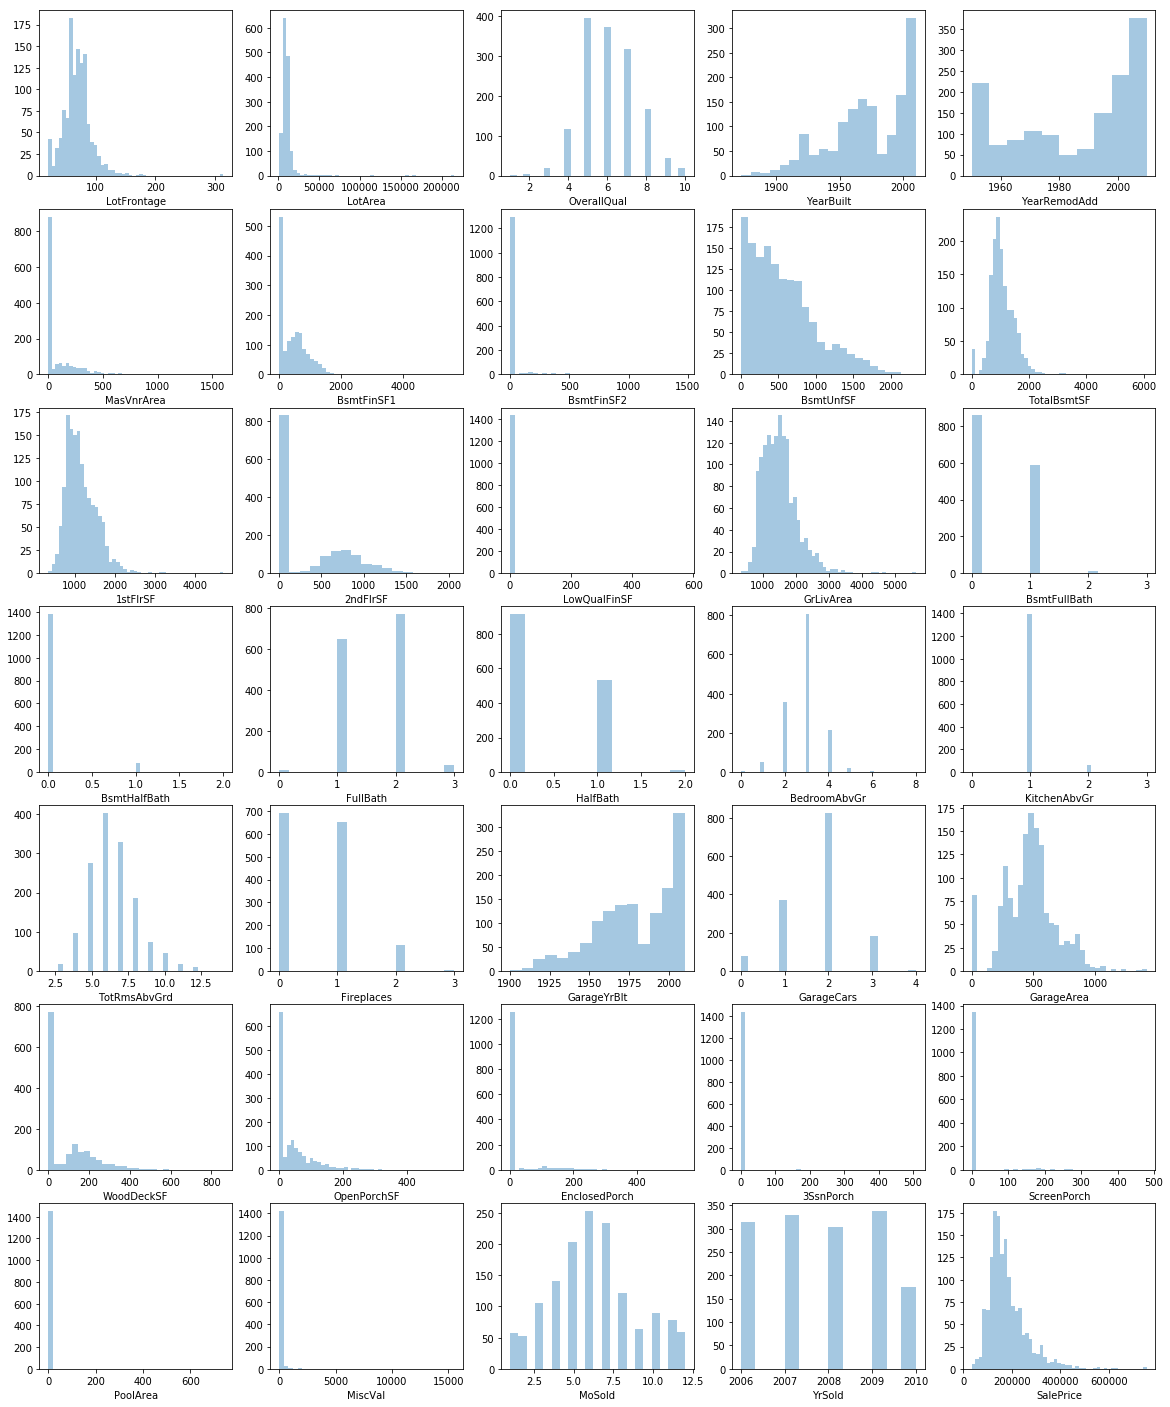

In [12]:
f, axes = plt.subplots(7, 5, figsize=(20,25))
for i in range(7):
    for j in range(5):
        sns.distplot(continuous.iloc[:,5*i+j].dropna(), ax=axes[i,j], kde=False)

Most of these variables are not even close to being normally distributed, and of those that are, many havelong tails. One thing that stands out when looking at these graphs is that the 1950-1954 bin for YearRemodAdd seems to be high.

In [24]:
(continuous.YearRemodAdd
 .value_counts()
 .reset_index()
 .sort_values(by=['index']))

,index,YearRemodAdd
0,1950,178
60,1951,4
58,1952,5
46,1953,10
32,1954,14
49,1955,9
45,1956,10
47,1957,9
29,1958,15
24,1959,18


It seems implausible that 178 houses were remodeled in 1950 and that this was the first year that remodels ocurred. I'm guessing that anything remodeled before 1950 was entered as 1950. Assuming this is true, it should not be used in modeling.

In [13]:
for column in categorical.columns:
    if column == 'MasVnrType':
        categorical.loc[:,column].fillna('None', inplace=True)
        continue
    categorical.loc[:,column].cat.add_categories(['None'], inplace=True)
    categorical.loc[:,column].fillna('None', inplace=True)

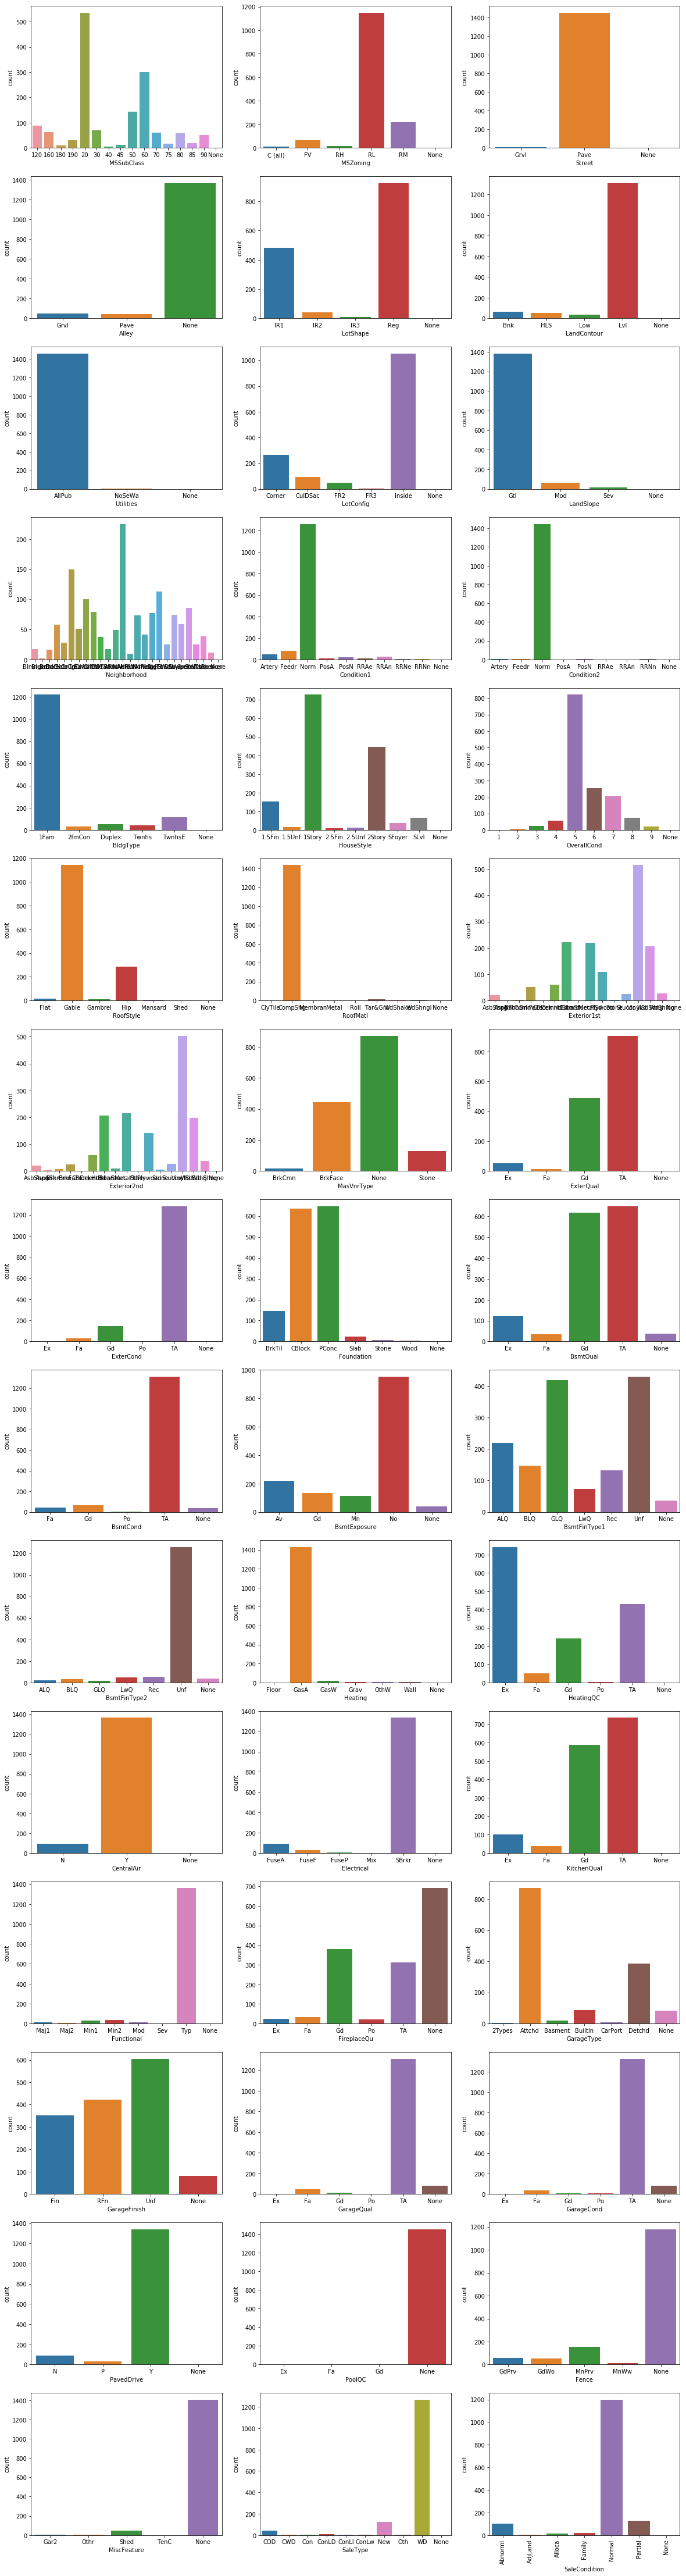

In [14]:
f, axes = plt.subplots(15, 3, figsize=(20,80))
for i in range(15):
    for j in range(3):
        sns.countplot(categorical.iloc[:,3*i+j], ax=axes[i,j])
        plt.xticks(rotation=90)

Many of the categorical variables are dominated by a single category.
One interesting thing is to look at OverallCond where the values have a strong assymetry with very few houses having a rating below 5.

## Bivariate Analysis
In this section I will look at the variables most highly correlated with SalePrice and look for colinear variables.

In [25]:
(df.corr()
 .SalePrice
 .sort_values())

KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
YrSold          -0.028923
LowQualFinSF    -0.025606
MiscVal         -0.021190
BsmtHalfBath    -0.016844
BsmtFinSF2      -0.011378
3SsnPorch        0.044584
MoSold           0.046432
PoolArea         0.092404
ScreenPorch      0.111447
BedroomAbvGr     0.168213
BsmtUnfSF        0.214479
BsmtFullBath     0.227122
LotArea          0.263843
HalfBath         0.284108
OpenPorchSF      0.315856
2ndFlrSF         0.319334
WoodDeckSF       0.324413
LotFrontage      0.351799
BsmtFinSF1       0.386420
Fireplaces       0.466929
MasVnrArea       0.477493
GarageYrBlt      0.486362
YearRemodAdd     0.507101
YearBuilt        0.522897
TotRmsAbvGrd     0.533723
FullBath         0.560664
1stFlrSF         0.605852
TotalBsmtSF      0.613581
GarageArea       0.623431
GarageCars       0.640409
GrLivArea        0.708624
OverallQual      0.790982
SalePrice        1.000000
Name: SalePrice, dtype: float64

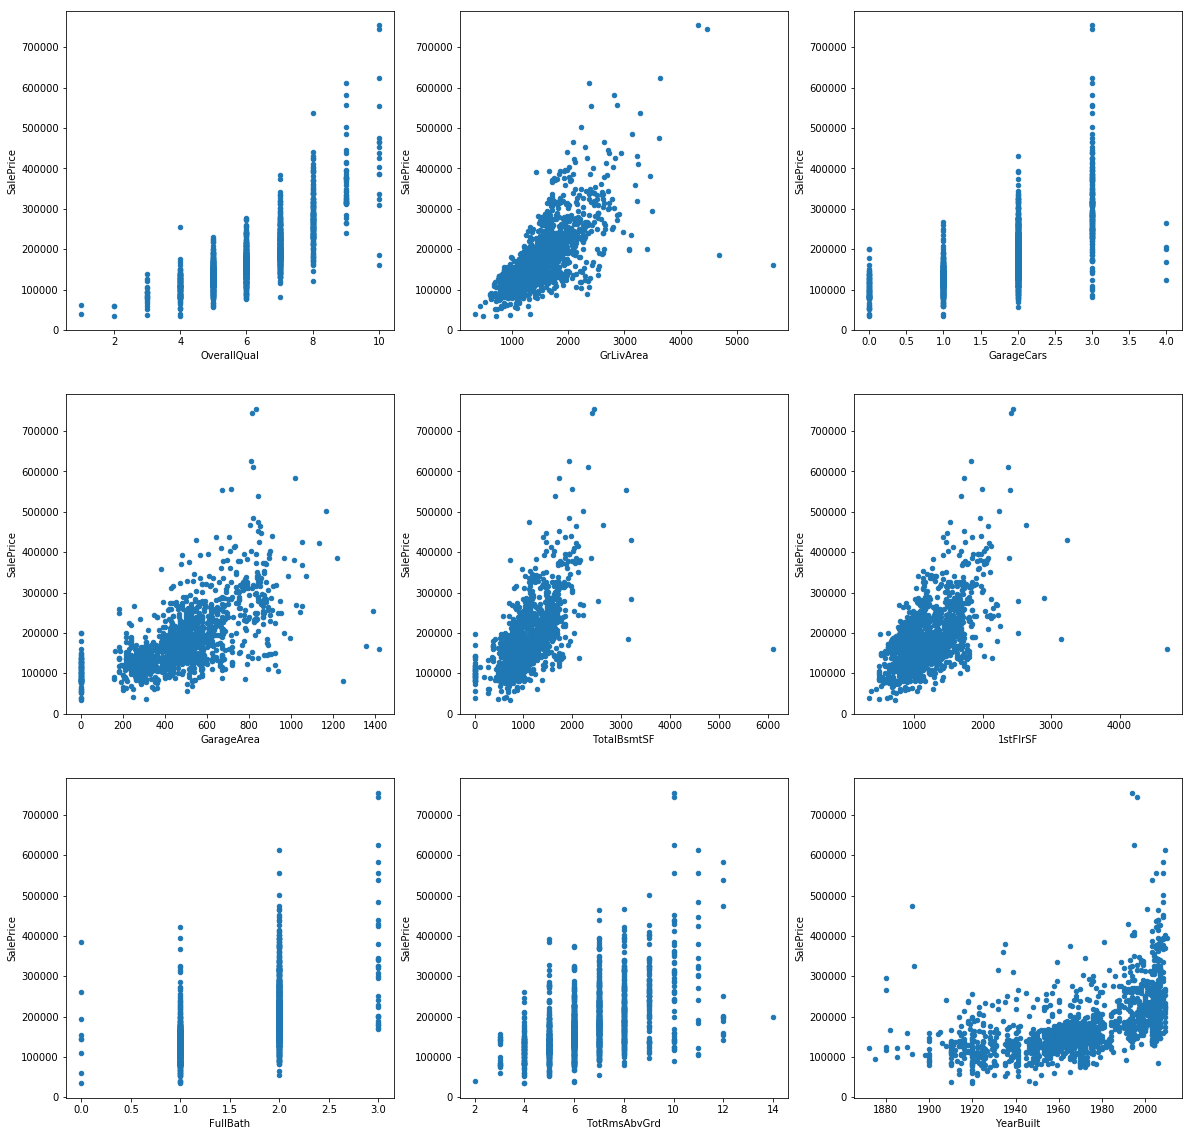

In [36]:
f, axes = plt.subplots(3, 3, figsize=(20,20))
df.plot.scatter(x="OverallQual", y="SalePrice", ax=axes[0,0])
df.plot.scatter(x="GrLivArea", y="SalePrice", ax=axes[0,1])
df.plot.scatter(x="GarageCars", y="SalePrice", ax=axes[0,2])
df.plot.scatter(x="GarageArea", y="SalePrice", ax=axes[1,0])
df.plot.scatter(x="TotalBsmtSF", y="SalePrice", ax=axes[1,1])
df.plot.scatter(x="1stFlrSF", y="SalePrice", ax=axes[1,2])
df.plot.scatter(x="FullBath", y="SalePrice", ax=axes[2,0])
df.plot.scatter(x="TotRmsAbvGrd", y="SalePrice", ax=axes[2,1])
df.plot.scatter(x="YearBuilt", y="SalePrice", ax=axes[2,2])

Looking at these plots, we can see that these high correlation factors appear to be real.

In [37]:
corr_mat = df.corr()

In [38]:
corr_mat7 = (corr_mat
              .apply(lambda srs: srs
                     .map(lambda x: 
                          None if ((x>-0.7) and (x<0.7)) or x==1 else x)))

In [40]:
corr_mat7.iloc[corr_mat7.notnull().sum().values.astype(bool),
               corr_mat7.notnull().sum().values.astype(bool)]

,OverallQual,YearBuilt,TotalBsmtSF,1stFlrSF,GrLivArea,TotRmsAbvGrd,GarageYrBlt,GarageCars,GarageArea,SalePrice
OverallQual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.790982
YearBuilt,NaN,NaN,NaN,NaN,NaN,NaN,0.825667,NaN,NaN,NaN
TotalBsmtSF,NaN,NaN,NaN,0.81953,NaN,NaN,NaN,NaN,NaN,NaN
1stFlrSF,NaN,NaN,0.81953,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GrLivArea,NaN,NaN,NaN,NaN,NaN,0.825489,NaN,NaN,NaN,0.708624
TotRmsAbvGrd,NaN,NaN,NaN,NaN,0.825489,NaN,NaN,NaN,NaN,NaN
GarageYrBlt,NaN,0.825667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GarageCars,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.882475,NaN
GarageArea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.882475,NaN,NaN
SalePrice,0.790982,NaN,NaN,NaN,0.708624,NaN,NaN,NaN,NaN,NaN


### Highly Correlated Variables
For a reliable model, one of each of these will likely need to be removed
`YrBuilt      : GarageYrBuilt - 0.825667`<br>
`TotRmsAbvGrd : GrLivArea     - 0.825489`<br>
`1stFlrSF     : TotalBsmtSF   - 0.819530`<br>
`GarageArea   : GarageCars    - 0.882475`<br>